In [1]:
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig
from PIL import Image
import requests
import torch
import os
import matplotlib.pyplot as plt
import re

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'

In [3]:
# load the processor
processor = AutoProcessor.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='auto'
)

In [4]:
# load the model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    #torch_dtype='auto',
    torch_dtype=torch.float16,
    device_map='auto'
)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [36]:
"""
Gibt zwei Arrays zurück, die jeweils die tasks (strings) bzw die Bilder enthalten.
Geht die Folder durch und liest die task aus lang.txt und das bild aus im_0
"""
def extract_tasks_and_images(path_to_directory):
    tasks = []
    images = []

    for experiment in os.listdir(path_to_directory):
        if experiment.startswith("."):
            continue
        subdir_path = os.path.join(path_to_directory, experiment)
        task_file_path = os.path.join(subdir_path, "lang.txt")

        # Get Task
        with open(task_file_path, "r") as lang_file:
            task = lang_file.read()
            tasks.append(task)

        # Get image
        for file in os.listdir(subdir_path):
                    if file.startswith("im_") and file.endswith((".png", ".jpg", ".jpeg")):
                        image_path = os.path.join(subdir_path, file)
                        image = Image.open(image_path)
                        images.append(image)

    return tasks, images        

In [63]:
"""
Der model-output ist bei mir (obj1, (x1, y1)), (obj2, (x2, y2,)), ...
Die Methode zieht da einfach die einzelnen Sachen raus
Gibt einen Array aus 3-Tupeln zurück [(ob1, x1, y1), (ob2, x2, y2), ...]
"""
def extract_objects_from_model_output(model_output):
    #Find pattern: (object-name, (x, y))
    pattern = r'\(([^,]+),\s*\((\d+\.?\d*),\s*(\d+\.?\d*)\)\)'
    matches = re.findall(pattern, model_output)
    
    objects = []
    for obj, x, y in matches:
        objects.append((obj.strip(), int(float(x)), int(float(y))))
    return objects


"""
Scaled die Koordinaten auf die Größe des images und gibt diese zurück
"""
def scale_coordinates(coordinates, image_width, image_height):
    scaled_coordinates = []
    for x, y in coordinates:
        # Scale coordinates to the image size
        scaled_x = x / 100 * image_width
        scaled_y = y / 100 * image_height
        scaled_coordinates.append((int(scaled_x), int(scaled_y)))
    return scaled_coordinates

In [61]:
"""
Nimmt die Objekte und visualisiert diese auf dem image.
labels ist ein Array, der die jeweiligen labels sind, die dann angezeigt werden (Also Prompt: 1, Prompt: 2, ... oder Temp: 1, Temp: 2, ...)
sets_of_objects is ein Array, der Listen enthält, welche die Objekte speichern. Also jede Liste ist ein run mit dem Model (Hier werden ja immer mehrere Punkte ausgegeben, deshalb ist ein run selbst auch eine Liste)
Und weil wir ja bspw. alle temperatures, oder alle prompts in einer Grafik haben wollen, müssen die halt alle jeweils nochmal in einer Liste zusammengefasst werden
"""
def visualize_points_on_image(image, labels, sets_of_objects):
    plt.imshow(image, alpha=0.5)
    image_width, image_height = image.size


    for i, objects in enumerate(sets_of_objects):
        coordinates = [(obj[1], obj[2]) for obj in objects]
        scaled_coordinates = scale_coordinates(coordinates, image_width, image_height)
        objects = [(obj[0], *scaled_coordinate) for obj, scaled_coordinate in zip(objects, scaled_coordinates)]
    
        # Extract and plot the points
        x_coords = [coord[1] for coord in objects]
        y_coords = [coord[2] for coord in objects]
        plt.scatter(x_coords, y_coords, marker='o', label=labels[i])
        #TODO - Verschiedene Sets - Verschiedene marker 
    
        # Annotate each point with its object name
        for obj, x, y in objects:
            plt.text(x, y, obj, color='black', fontsize=9, ha='right', va='bottom')
    
    # Add labels and show the plot
    plt.title("Coordinates on Image")
    plt.legend(loc="lower right")
    plt.axis("on")  # Show axes
    plt.show()
    plt.close()

In [64]:
"""
Hier sind die prompts für die VLM. Der Anfang und das Ender sind immer identisch und die Task wird im Skript später automatisch eingesetzt.
Die verschiedenen Prompts können dann über die Liste ausgewählt werden.
"""

prompt_start = "You are the robot in the picture. Your task is to: "

prompts = []
prompt_1 = "First, create a plan how to execute the task. Afterwards, find the relevant objects from your plan in the picture and point to them as well as the robot arm, if that is in the picture."
prompt_2 = "To complete this taks, First create a plan to execute the task. Afterwards find the relevant objects for the task. Then point to the relevant objects in the picture, as well as the robot arm if that is in the picture."
#prompt_3 = "To complete this taks, first find the relevant objects from the task. Reason, why you need them to complete the task. Then pinpoint the relevant objects in the picture, as well as the robot arm."
#prompt_4 = "To complete this task, first find the relevant objects in the picture. Afterwards create a plan to execute the task."
#prompt_4 = "Find objects, that are not relevant for completing this task."

prompts = [prompt_1, prompt_2]
#prompts = [prompt_1, prompt_2, prompt_3, prompt_4]
prompt_end = " Your output format should be like this: (name of object 1, (x1, y1)), (name of object 2, (x2, y2)), ..., with x and y beeing integer values. Dont output anything else."

In [56]:
temperatures = [0.3, 0.4, 0.6, 0.7]

In [57]:
"""
Führt die inference auf dem image aus
"""
def do_inference_on_image(image, task, prompt, temperature=0.2):
    # Process inputs
    inputs = processor.process(
        images=image,
        text=prompt_start + task + prompt + prompt_end
    )
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

    # generate output
    with torch.autocast(device_type="cuda", enabled=True, dtype=torch.bfloat16):
      output = model.generate_from_batch(
          inputs,
          GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>", temperature=temperature, do_sample=True),
          tokenizer=processor.tokenizer
      )
    generated_tokens = output[0,inputs['input_ids'].size(1):]
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    return generated_text
    
    

Task: 1
Task: Move the can from the top left of the burner to the bottom left of the burner
confidence: 0.8

Different Prompts:
Prompt: 1 - Output:  (burner, (50, 40)), (can, (25, 25)), (robot arm, (65, 15)), (spatula, (45, 38)), (pot, (70, 48))
Prompt: 2 - Output:  (can, (25.6, 25.6)), (burner, (36.6, 42.0)), (robot arm, (66.6, 15.1))


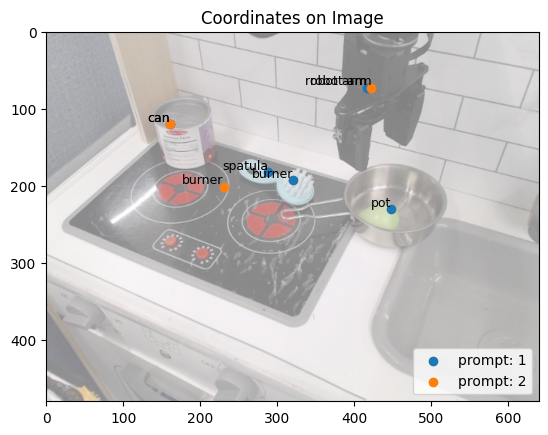



Multiple runs:
Run: 1 - Output:  (can, (26.4, 25.4)), (burner, (40.4, 51.7)), (robot arm, (68.0, 13.1)), (spatula, (47.0, 38.3))
Run: 2 - Output:  (can, (27.7, 27.7)), (burner, (41.8, 48.6)), (robot arm, (65.4, 14.1)), (spatula, (48.0, 40.1))
Run: 3 - Output:  (can, (25.5, 27.0)), (burner, (36.3, 49.4)), (robot arm, (66.2, 16.0)), (pot, (72.1, 48.1))


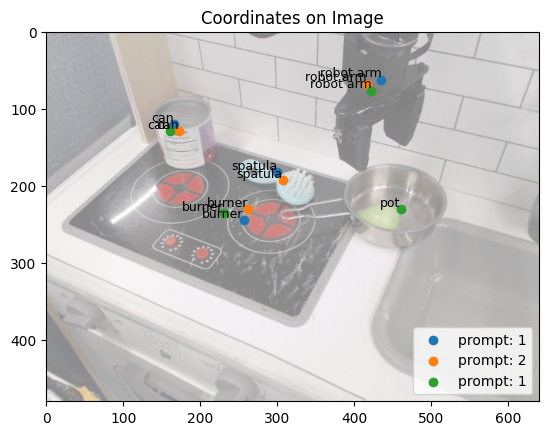



Testing different Temperatures:
Temperature: 0.3 - Output:  (can, (27.2, 26.8)), (burner, (36.2, 49.5)), (robot arm, (65.1, 15.9))
Temperature: 0.4 - Output:  (can, (27.0, 28.1)), (burner, (41.4, 51.8)), (robot arm, (66.0, 17.1))
Temperature: 0.6 - Output:  (can, (25, 25)), (burner, (35, 40)), (robot arm, (65, 10))
Temperature: 0.7 - Output:  (can, (26.3, 29.8)), (burner, (44.8, 54.7)), (robot arm, (67.8, 18.8))


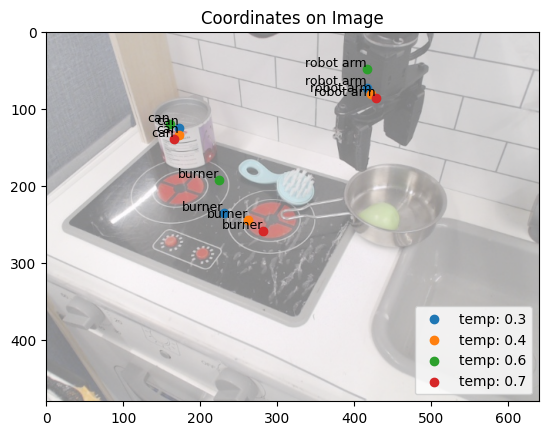



Task: 2
Task: pick up red srewdriver

Different Prompts:
Prompt: 1 - Output:  (red screwdriver, (40, 37)), (robot arm, (70, 15)), (red toolbox, (50, 20)), (white floor, (15, 80)), (wrench, (90, 85)), (screwdrivers, (50, 40))
Prompt: 2 - Output:  (red screwdriver, (40, 38)), (robot arm, (70, 10))


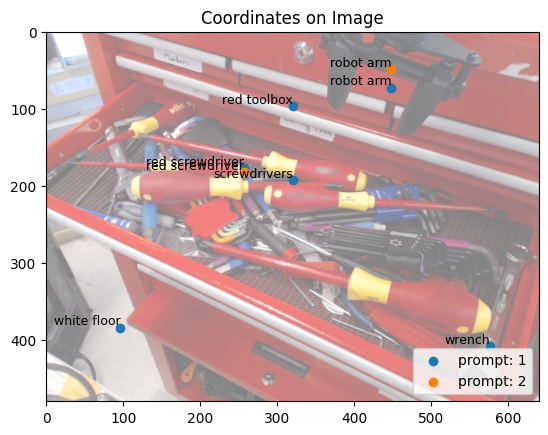



Multiple runs:
Run: 1 - Output:  (red screwdriver, (40, 37)), (robot arm, (70, 13)), (red toolbox, (50, 20)), (white floor, (15, 80))
Run: 2 - Output:  (red screwdriver, (33.0, 37.4)), (red screwdriver, (34.0, 41.0)), (robot arm, (71.4, 14.6)), (red toolbox, (50.7, 15.6))
Run: 3 - Output:  (red screwdriver, (33.2, 36.5)), (red screwdriver, (33.2, 41.0)), (robot arm, (65.2, 10.1)), (red toolbox, (50.8, 20.7))


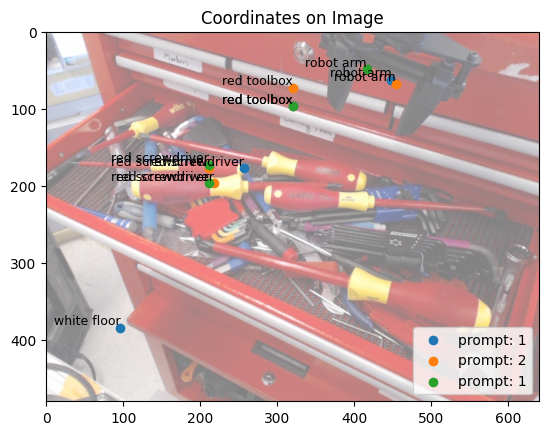



Testing different Temperatures:
Temperature: 0.3 - Output:  (red screwdriver, (35, 38)), (robot arm, (70, 13))
Temperature: 0.4 - Output:  (red screwdriver, (40, 37)), (robot arm, (68.2, 12.8))
Temperature: 0.6 - Output:  (red screwdriver, (26.6, 23.5)), (robot arm, (67.9, 12.5)), (red toolbox, (91.0, 17.4))
Temperature: 0.7 - Output:  (red screwdriver, (19.5, 28.6)), (robot arm, (65.1, 10.6)), (red toolbox, (50.2, 34.4))


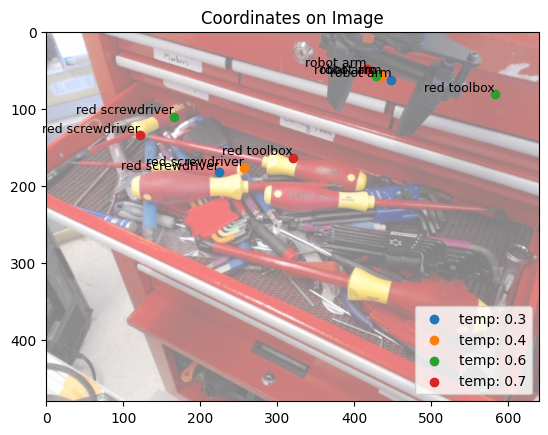



Task: 3
Task: take the eggplant and put it between the two right burners
confidence: 0.6

Different Prompts:
Prompt: 1 - Output:  (eggplant, (52.1, 43.7)), (robot arm, (55.5, 20.6)), (orange bowl, (60.5, 48.4)), (burners, (60.5, 58.7), (61.1, 76.3))
Prompt: 2 - Output:  (eggplant, (53.8, 44.2)), (orange bowl, (60.3, 47.3)), (robot arm, (55.9, 18.1))


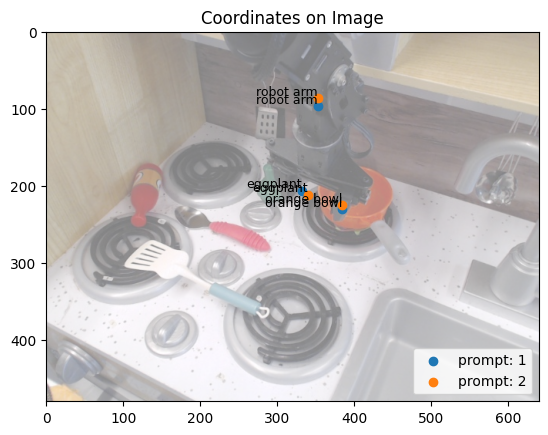



Multiple runs:
Run: 1 - Output:  (eggplant, (46.5, 42.4)), (robot arm, (55.9, 19.8)), (orange bowl, (60.7, 46.3)), (burners, (60.7, 57.0), (61.9, 76.0))
Run: 2 - Output:  (eggplant, (45.8, 45.8)), (robot arm, (54.9, 28.3)), (orange bowl, (60.9, 49.0))
Run: 3 - Output:  (eggplant, (48.6, 42.7)), (robot arm, (55.1, 20.9)), (orange bowl, (60.5, 48.0))


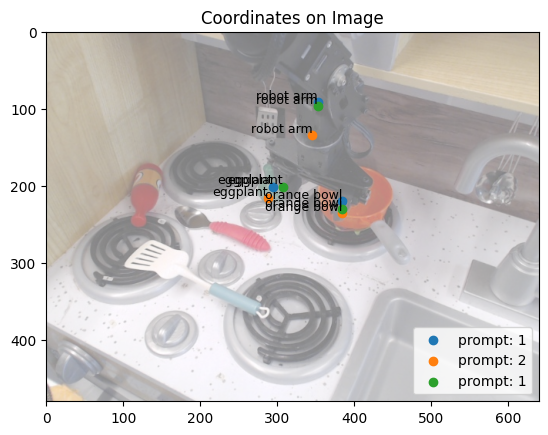



Testing different Temperatures:
Temperature: 0.3 - Output:  (eggplant, (54.1, 46.6)), (robot arm, (56.5, 26.3)), (orange bowl, (63.8, 46.6)), (burners, (58.4, 58.0), (62.6, 55.0))
Temperature: 0.4 - Output:  (eggplant, (54.3, 43.2)), (orange bowl, (58.9, 47.6)), (robot arm, (55.0, 25.8))
Temperature: 0.6 - Output:  (eggplant, (45, 43)), (orange bowl, (62, 49)), (robot arm, (56, 20))
Temperature: 0.7 - Output:  (eggplant, (51.9, 44.8)), (orange bowl, (57.8, 49.5)), (robot arm, (56.3, 28.8))


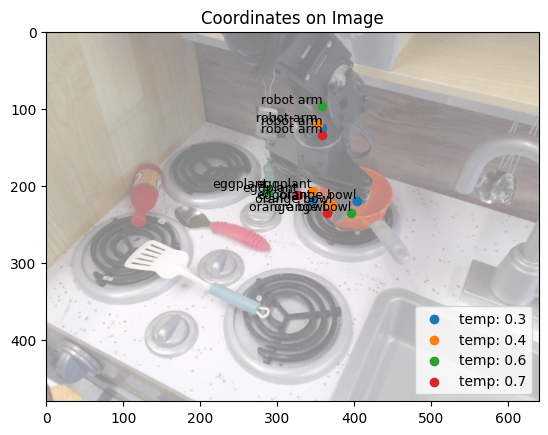



Task: 4
Task: move arch on the table and place it on top of another arch
confidence: 0.4

Different Prompts:
Prompt: 1 - Output:  (robot arm, (50, 50)), (arch, (40, 70)), (arch, (60, 60))
Prompt: 2 - Output:  (red arch, (42.1, 73.5)), (blue arch, (40.1, 66.0)), (robot arm, (45.1, 47.5))


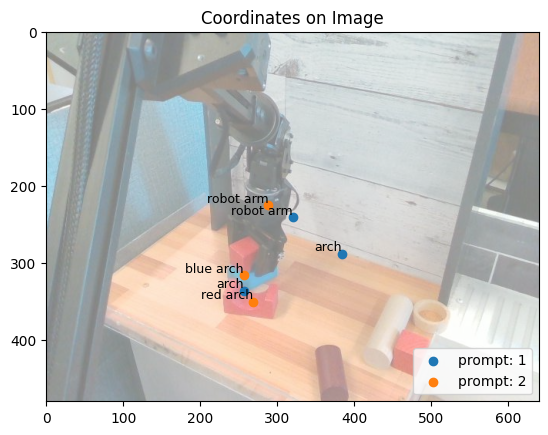



Multiple runs:
Run: 1 - Output:  (robot arm, (50, 50)), (arch, (40, 60)), (arch, (60, 70))
Run: 2 - Output:  (robot arm, (50, 50)), (arch, (40, 60)), (arch, (60, 70))
Run: 3 - Output:  (arch, (59.4, 78.1)), (robot arm, (48.0, 46.5)), (blue arch, (40.7, 67.0)), (red arch, (41.8, 74.4))


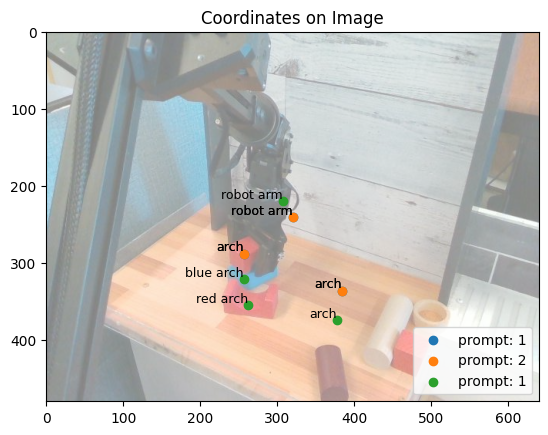



Testing different Temperatures:
Temperature: 0.3 - Output:  (red arch, (41.5, 72.6)), (blue arch, (40.9, 64.3)), (robot arm, (48.7, 38.9))
Temperature: 0.4 - Output:  (arch, (41.1, 68.8)), (arch, (41.2, 57.6)), (tube, (69.8, 79.0))
Temperature: 0.6 - Output:  (arch, (60.9, 88.1)), ( arch, (65.9, 77.2))
Temperature: 0.7 - Output:  (red arch, (41.3, 74.4)), (blue arch, (41.1, 63.8)), (brown cylinder, (58.8, 89.4))


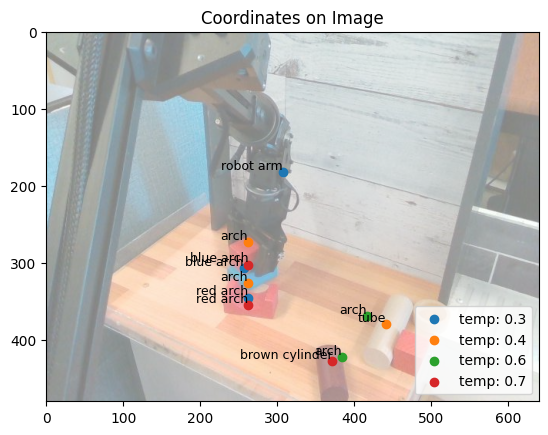



Task: 5
Task: take sushi out of pan

Different Prompts:
Prompt: 1 - Output:  (pan, (32.5, 25.9)), (sushi, (31.2, 22.9)), (robot arm, (59.5, 36.9))
Prompt: 2 - Output:  (pan, (33.5, 28.7)), (sushi, (31.4, 23.4)), (robot arm, (59.0, 26.5))


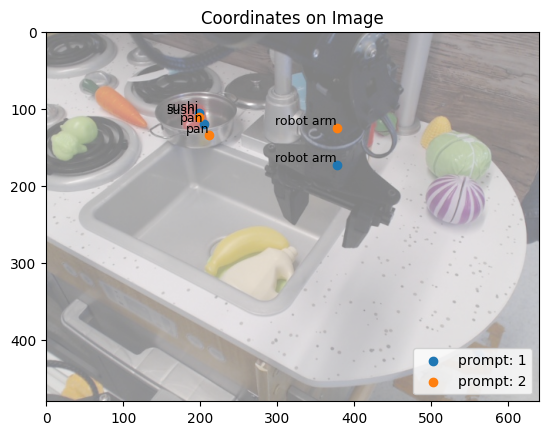



Multiple runs:
Run: 1 - Output:  (pan, (35.2, 26.8)), (sushi, (32.0, 23.0)), (robot arm, (58.6, 36.7))
Run: 2 - Output:  (pan, (33.5, 26.2)), (sushi, (32.0, 23.3)), (robot arm, (57.0, 36.5))
Run: 3 - Output:  (pan, (33.5, 25.9)), (sushi, (32.1, 23.2)), (robot arm, (59.0, 35.8)), (carrot, (15.2, 19.4))


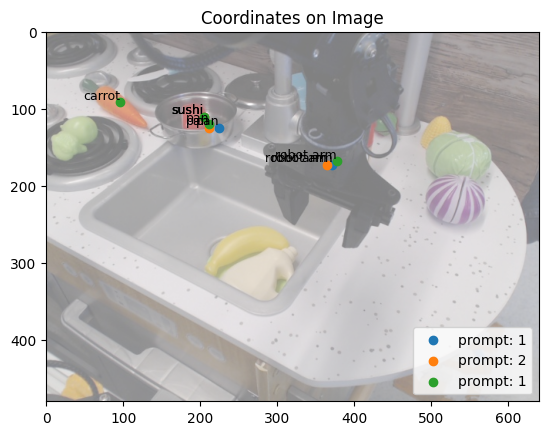



Testing different Temperatures:
Temperature: 0.3 - Output:  (pan, (32.2, 26.7)), (sushi, (31.7, 22.2)), (robot arm, (57.6, 29.4))
Temperature: 0.4 - Output:  (pan, (41.2, 24.3)), (sushi, (31.0, 22.4)), (robot arm, (58.9, 34.8))
Temperature: 0.6 - Output:  (pan, (36.8, 22.5)), (sushi, (32.8, 21.0)), (robot arm, (62.4, 38.7))
Temperature: 0.7 - Output:  (pan, (32.5, 24.1)), (sushi, (30.6, 23.5)), (robot arm, (58.6, 21.3))


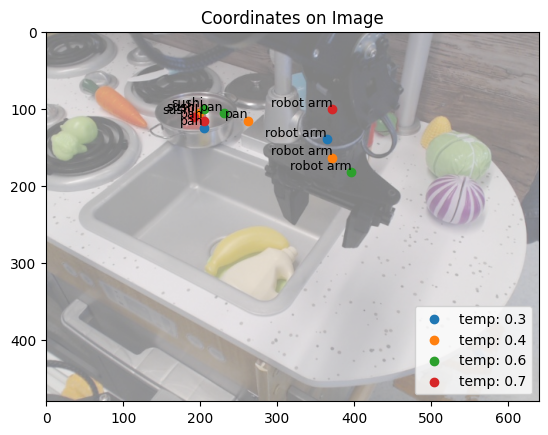



Task: 6
Task: pick up glass cup

Different Prompts:
Prompt: 1 - Output:  (glass cup, (37.6, 61.5)), (robot arm, (58.9, 13.8)), (dishwasher rack, (50.0, 38.1)), (white cup, (72.2, 27.1)), (white cup, (79.6, 49.5))
Prompt: 2 - Output:  (glass cup, (42.4, 63.4)), (robot arm, (55.9, 13.8)), (glass cup, (30.1, 34.2)), (white cup, (72.0, 28.5))


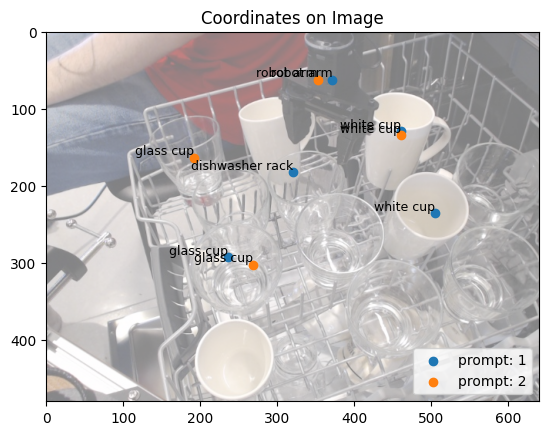



Multiple runs:
Run: 1 - Output:  (glass cup, (40.3, 59.4)), (robot arm, (57.7, 15.0)), (dishwasher rack, (50.5, 38.8)), (white cup, (72.4, 28.4)), (white cup, (76.1, 47.8))
Run: 2 - Output:  (glass cup, (37.8, 62.9)), (robot arm, (56.7, 16.5)), (dishwasher rack, (50.0, 48.2)), (white cup, (70.5, 28.9)), (white cup, (76.2, 49.4))
Run: 3 - Output:  (glass cup, (39.6, 63.0)), (robot arm, (57.0, 13.2)), (dishwasher rack, (50.2, 37.0)), (white cup, (70.6, 29.2))


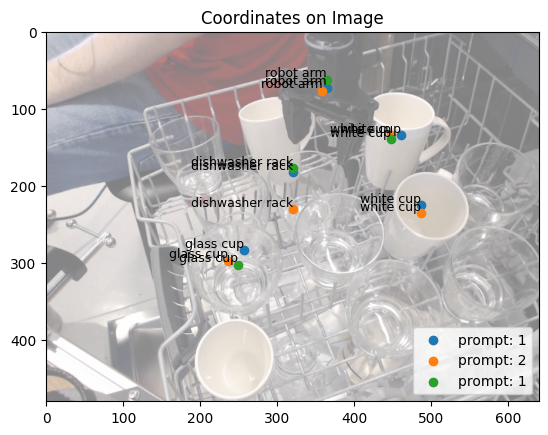



Testing different Temperatures:
Temperature: 0.3 - Output:  (glass cup, (41.1, 63.5)), (robot arm, (57.0, 18.0))
Temperature: 0.4 - Output:  (glass cup, (43.8, 63.0)), (robot arm, (55.4, 15.3))
Temperature: 0.6 - Output:  (glass cup, (38.9, 64.6)), (robot arm, (57.4, 17.0))
Temperature: 0.7 - Output:  (glass cup, (40.7, 60.6)), (robot hand, (59.0, 25.4))


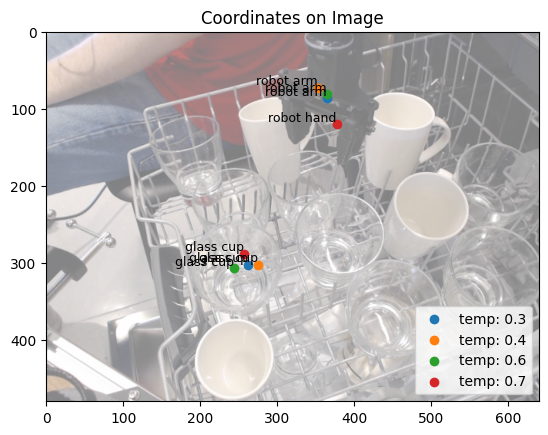



Task: 7
Task: open low fridge

Different Prompts:
Prompt: 1 - Output:  (low fridge, (60.4, 52.4)), (drawer, (84.2, 69.7)), (robot arm, (10.5, 27.9))
Prompt: 2 - Output:  (low fridge, (55, 50)), (drawer, (55, 50)), (robot arm, (10, 30))


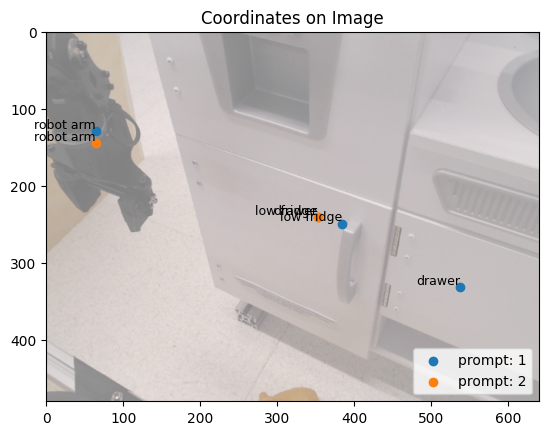



Multiple runs:
Run: 1 - Output:  (low fridge, (52.4, 39.0)), (robot arm, (10.1, 27.2)), (drawer, (80.7, 67.0)), (drawer handle, (61.6, 56.3)), (drawer vent, (90.2, 46.1)), (floor, (30.3, 81.7))
Run: 2 - Output:  (low fridge, (60.8, 52.0)), (drawer, (85.5, 71.5)), (robot arm, (8.9, 33.9))
Run: 3 - Output:  (low fridge, (54.5, 48.2)), (drawer, (81.7, 68.1)), (robot arm, (10.1, 28.3))


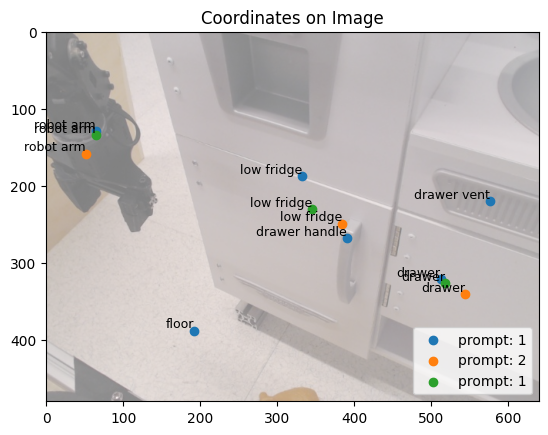



Testing different Temperatures:
Temperature: 0.3 - Output:  (low fridge, (60, 40)), (drawer, (61, 71)), (robot arm, (10, 30))
Temperature: 0.4 - Output:  (low fridge, (51.1, 46.4)), (drawer, (84.6, 67.0)), (robot arm, (11.8, 29.9))
Temperature: 0.6 - Output:  (low fridge, (65, 36)), (drawer, (64.8, 56)), (robot arm, (6.8, 19))
Temperature: 0.7 - Output:  (low fridge, (53.4, 44.3)), (drawer, (61.0, 63.8)), (robot arm, (9.7, 38.6))


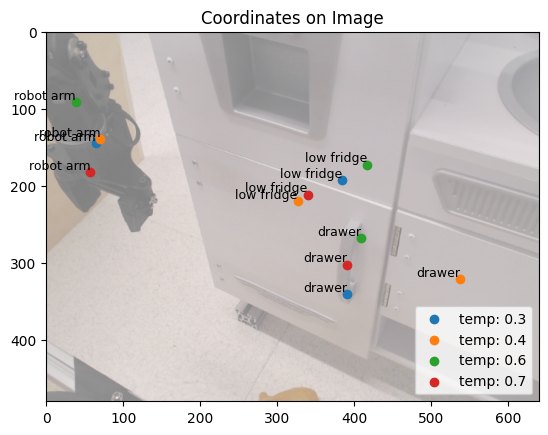



Task: 8
Task: Place the pot to the right of the blue fork.
Move silver pot to lower right corner of the table.

Different Prompts:
Prompt: 1 - Output:  (blue fork, (35.1, 60.1)), (silver pot, (42.0, 31.6)), (wooden table, (56.2, 57.7)), (robot arm, (90.5, 50.8))
Prompt: 2 - Output:  (blue fork, (30, 60)), (silver pot, (45, 35)), (canned food, (20, 40)), (wooden table, (50, 50)), (white wall, (60, 20)), (robot arm, (5, 90))


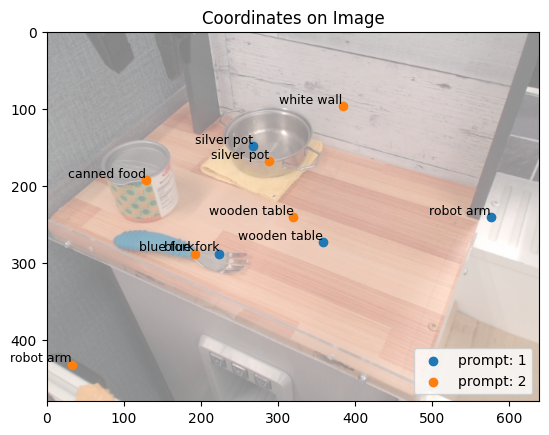



Multiple runs:
Run: 1 - Output:  (blue fork, (29.0, 59.3)), (silver pot, (43.1, 31.0)), (pot holder, (40.6, 37.3)), (table, (58.5, 58.9)), (robot arm, (50.0, 50.0))
Run: 2 - Output:  (blue fork, (30, 60)), (silver pot, (45, 35)), (pot holder, (40, 38)), (table, (50, 50)), (robot arm, (50, 50))
Run: 3 - Output:  (blue fork, (30, 60)), (silver pot, (45, 35)), (wooden table, (50, 50)), (can, (20, 40)), (kitchen, (100, 100))


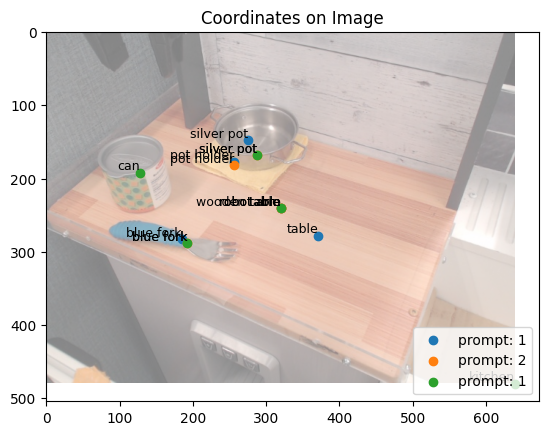



Testing different Temperatures:
Temperature: 0.3 - Output:  (pot, (51, 35)), (fork, (33, 59)), (canned good, (21, 42)), (robot arm, (50, 50))
Temperature: 0.4 - Output:  (blue fork, (31.0, 60.5)), (silver pot, (45.2, 32.8)), (pot holder, (41.6, 39.8)), (table, (59.4, 57.1))
Temperature: 0.6 - Output:  (blue fork, (32.9, 61.1)), (silver pot, (43.7, 33.3)), (can, (19.9, 43.3)), (wooden table, (57.4, 55.2)), (wooden wall, (70.8, 22.9)), (robot arm, (51.2, 65.5))
Temperature: 0.7 - Output:  (blue fork, (37.7, 60.8)), (silver pot, (43.6, 33.4)), (canned good, (21.6, 41.2))


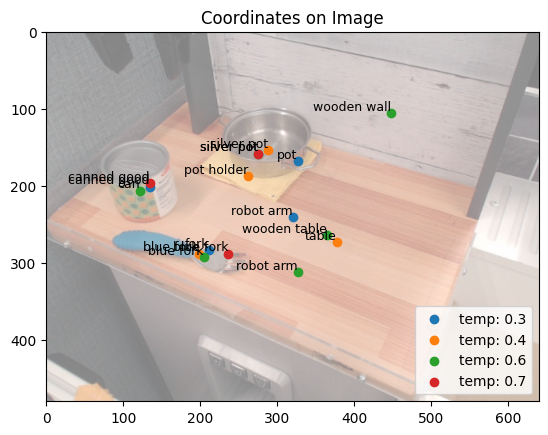

In [62]:
"""
Das ist mein Script, dass die Experimente ausführt
Für alle tasks 3 mal das gleiche: 1. Für verschiedene prompts, 2. Für das gleiche prompt und gleiche temperature, 3. Für verschiedene temperatures 
"""

#tasks, images = extract_tasks_and_images("./data")
tasks, images = extract_tasks_and_images("./xai-praktikum/molmo/data2")

for i in range(len(tasks)):
    print(f"Task: {i + 1}")
    image = images[i]
    task = tasks[i]
    labels = []
    
    
    objects_of_all_prompts = []
    print(f"Task: {task}")
    print("Different Prompts:")
    for j in range(len(prompts)):
        labels.append(f"prompt: {j + 1}")
        prompt = prompts[j]
        
        output = do_inference_on_image(image, task, prompt)
        objects_of_all_prompts.append(extract_objects_from_model_output(output))
    
        print(f"Prompt: {j + 1} - Output: {output}")

    
    visualize_points_on_image(image, labels, objects_of_all_prompts)
    print("")
    print("")


    labels = []
    objects_of_all_prompts = []
    print("Multiple runs:")
    for j in range(3):
        labels.append(f"Run: {j + 1}")
        
        output = do_inference_on_image(image, task, prompts[0])
        objects_of_all_prompts.append(extract_objects_from_model_output(output))
    
        print(f"Run: {j + 1} - Output: {output}")

    visualize_points_on_image(image, labels, objects_of_all_prompts)
    print("")
    print("")

    #"""
    labels = []
    objects_of_all_prompts = []
    print("Testing different Temperatures:")
    for j in range(len(temperatures)):
        temp = temperatures[j]
        labels.append(f"temp: {temp}")
        
        output = do_inference_on_image(image, task, prompts[1], temp)
        objects_of_all_prompts.append(extract_objects_from_model_output(output))
    
        print(f"Temperature: {temp} - Output: {output}")

    visualize_points_on_image(image, labels, objects_of_all_prompts)
    print("")
    print("")
    #"""